In [2]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from numpy import *
from scipy.integrate  import quad
import cmath
%matplotlib inline   

In [3]:
#import commands
import subprocess
import sys

In [4]:
print(plt.style.available)
plt.style.use('classic')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [5]:
def σSI(laSi,Mdmi):
    mp = 0.938
    fp = 0.3
    mh = 125.0
    sigmaSI_i = np.zeros(len(laSi))
    for i in range(len(laSi)):
        μR = mp*Mdmi[i]/( mp + Mdmi[i] )        
        sigmaSI_i[i] = ( laSi[i]**2 * μR**2 * mp**2 * fp**2)/(1.0*np.pi*mh**4*Mdmi[i]**2 )
    return sigmaSI_i*0.389379*1e9 ## in pb

In [6]:
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.minor.size'] = 4

#mpl.rcParams['xtick.labelsize'] = 50
mpl.rc('text', usetex=True)
#mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"

In [13]:
#DE_dataDD=np.loadtxt('DE-results-singlet-DD.txt')
DE_dataDD=np.loadtxt('all-DE-results-singlet-DD.txt')
##points obtained with Differential Evolution with no restriction on the value of the likelihood
namesDD=['logmS','loglaS','logmu3','omegaS','sigmaSI','loglike'] 
### loglike means: -2log(L)
###  logms, loglas, logmu3 mean log10(ms),log10(las),log10(mu3)
ydata1=pd.DataFrame(DE_dataDD,columns=namesDD)
print (ydata1.shape)
ydata1['mS'] = 10**ydata1.logmS
ydata1['laS'] = 10**ydata1.loglaS
ydata1['mu3'] = 10**ydata1.logmu3
ydata1['like'] = np.exp(-ydata1.loglike/2)
print (ydata1.shape)

(300300, 6)
(300300, 10)


In [14]:
print (max(ydata1['like']))
print (max(ydata1['loglike']))
print (min(ydata1['like']))
print (min(ydata1['loglike']))

0.9999913149116445
3.0913599866560004e+19
0.0
1.737025214215626e-05


In [16]:
## Choosing points at 2σ and 1σ CI 
## CAUTION: no stability bound has been applied
Lmax=max(ydata1["loglike"])
#Lmin=np.min(ydata1["loglike"])
ydata3 = ydata1[(ydata1["loglike"] - Lmax ) < 5.99] ## 2σ
ydata4 = ydata3[(ydata3["loglike"] - Lmax ) < 2.30] ## 1σ
print (shape(ydata3))
print (shape(ydata4))

(300300, 10)
(300300, 10)


In [18]:
## Routine that make a 2D profile likelihood
## df_: Pandas dataframe with the data 
## xvar_ , yvar_ : free parameters that won't be maximized
## Nx_, Ny_ : number of boxes in xvar_ and yvar_ axis
## Returns an nparray with (midx,midy,Lmax) where midx and midy are the coordinates of the center of the box and
## Lmax is the maximum value of L in such a box
def profiling2D(df_,xvar_,yvar_,χvar_,Nx_,Ny_):
    x_ = np.logspace(min(log10(df_[xvar_])), max(log10(df_[xvar_])), Nx_)
    y_ = np.logspace(min(log10(df_[yvar_])), max(log10(df_[yvar_])), Ny_)
    dx_ = (log10(x_[1]) - log10(x_[0]))
    dy_ = (log10(y_[1]) - log10(y_[0]))
    midx_ = 10**(log10(x_[:-1])+dx_/2)
    midy_ = 10**(log10(y_[:-1])+dy_/2)
    listarr_ = []
    for xpos_ in range(len(x_)-1):
        for ypos_ in range(len(y_)-1):
            tmpdata_ = df_[np.logical_and(np.logical_and(df_[xvar_]>x_[xpos_],df_[xvar_]<x_[xpos_+1]),np.logical_and(df_[yvar_]>y_[ypos_],df_[yvar_]<y_[ypos_+1]))]
            tmplike_ = np.max(tmpdata_[χvar_])
            listarr_.append(([midx_[xpos_],midy_[ypos_],tmplike_]))
    listarr_ = np.asarray(listarr_)         
    return listarr_     

In [19]:
Lmax = np.max(ydata1.like) ## maximum value of L in all the data. 
## Notice that χ_min^2 = -2 log(Lmax) = loglike.max
## Notice also that χ_min^2 is basically zero. 
bestfitydata1=ydata1[ydata1.like == Lmax]  ## Identifying the best fit point (the one with Lmax)

In [20]:
## 2D profile likelihod (mS,laS) with points satisfying Δχ^2 = χ^2 -χ_min^2 < 5.99
arr_mS_laS = profiling2D(ydata1,'mS','laS','like',120,120)
arr_mS_laS_2 = arr_mS_laS[-2*np.log(arr_mS_laS[:,2]/Lmax ) < 5.99]
print (arr_mS_laS_2.shape)

(1038, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


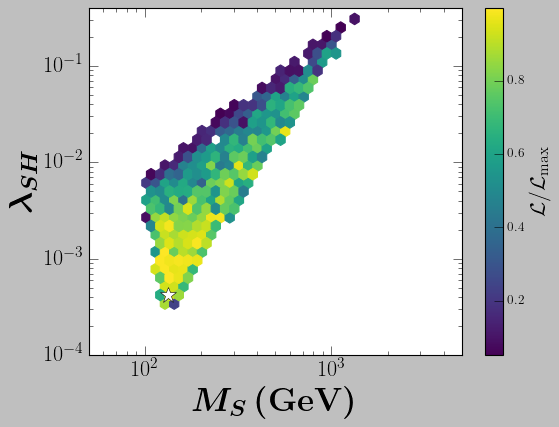

In [25]:
## 
plt.figure(figsize=(7.2,5.5))
#plt.hexbin(arr_mS_laS_2[:,0],arr_mS_laS_2[:,1],-2*np.log( arr_mS_laS_2[:,2]/Lmax ),gridsize=40,yscale='log',xscale='log',alpha=1, cmap = "viridis")
#c.set_label(r'$\Delta\chi^2$',size=20)
plt.hexbin(arr_mS_laS_2[:,0],arr_mS_laS_2[:,1], arr_mS_laS_2[:,2]/Lmax,gridsize=40,yscale='log',xscale='log',alpha=1, cmap = "viridis")
c=plt.colorbar()
## The color bar represents the likelihood ratio test: L/Lmax
c.set_label(r'$\mathcal{L}/\mathcal{L}_{\rm max}$',size=20)
plt.plot(bestfitydata1["mS"],bestfitydata1["laS"],'w*', markersize=15)
plt.xlabel(r'$\boldsymbol{M_{S}\,(\rm{GeV})}$',size=30)
plt.ylabel(r'$\boldsymbol{\lambda_{SH}}$',size=30)
plt.xlim(50,5000)
plt.ylim(1e-4,0.4)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

In [26]:
## 2D profile likelihod (mS,mu3) with points satisfying Δχ^2 = χ^2 -χ_min^2 < 5.99
arr_mS_mu3 = profiling2D(ydata1,'mS','mu3','like',120,120)
arr_mS_mu3_2 = arr_mS_mu3[-2*log( arr_mS_mu3[:,2]/Lmax ) < 5.99]
print (arr_mS_mu3_2.shape)

(3380, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


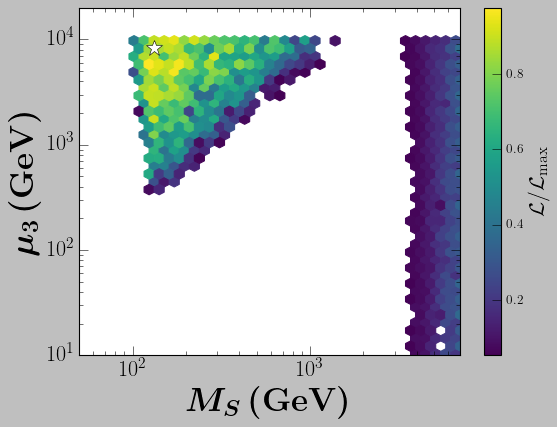

In [27]:
plt.figure(figsize=(7.2,5.5))
#plt.hexbin(arr_mS_mu3_2[:,0],arr_mS_mu3_2[:,1],-2*np.log( arr_mS_mu3_2[:,2]/Lmax ),gridsize=35,yscale='log',xscale='log',alpha=1, cmap = "viridis")
#c.set_label(r'$\Delta\chi^2$',size=20)
plt.hexbin(arr_mS_mu3_2[:,0],arr_mS_mu3_2[:,1], arr_mS_mu3_2[:,2]/Lmax,gridsize=35,yscale='log',xscale='log',alpha=1, cmap = "viridis")
c=plt.colorbar()
c.set_label(r'$\mathcal{L}/\mathcal{L}_{\rm max}$',size=20)
plt.plot(bestfitydata1["mS"],bestfitydata1["mu3"],'w*', markersize=15)
plt.xlabel(r'$\boldsymbol{M_{S}\,(\rm{GeV})}$',size=30)
plt.ylabel(r'$\boldsymbol{\mu_3\,(\rm{GeV})}$',size=30)
plt.xlim(50,7000)
plt.ylim(10,2e4)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

In [29]:
ydata2=ydata1[ydata1["mu3"]<4.0*ydata1["mS"]] ## Imposing vaccum stability condition 

In [30]:
## 2D profiles imposing vaccum stability condition 
arr_mS_laS = profiling2D(ydata2,'mS','laS','like',60,60)
arr_mS_mu3 = profiling2D(ydata2,'mS','mu3','like',60,60)
Lmax = np.max(ydata2.like)
bestfitydata2=ydata2[ydata2.like == Lmax]
arr_mS_laS2 = arr_mS_laS[-2*np.log(arr_mS_laS[:,2]/Lmax) < 5.99]
print (arr_mS_laS2.shape)
arr_mS_mu3_2 = arr_mS_mu3[-2*np.log(arr_mS_mu3[:,2]/Lmax) < 5.99]
print (arr_mS_mu3_2.shape)

(58, 3)
(848, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [31]:
Lmax2 = np.max(ydata2.like)  ## maximum value of L in all the data. 
bestfitydata2=ydata2[ydata2.like == Lmax2]  ## Identifying the best fit point (the one with Lmax2)

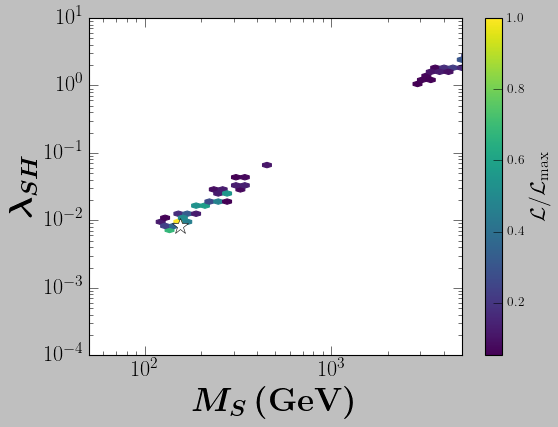

In [33]:
plt.figure(figsize=(7.2,5.5))
#plt.hexbin(arr_mS_laS2[:,0],arr_mS_laS2[:,1],-2*log(arr_mS_laS2[:,2]/Lmax2),gridsize=40,yscale='log',xscale='log',alpha=1, cmap = "viridis")
#c.set_label(r'$\Delta\chi^2$',size=20)
plt.hexbin(arr_mS_laS2[:,0],arr_mS_laS2[:,1],arr_mS_laS2[:,2]/Lmax2,gridsize=40,yscale='log',xscale='log',alpha=1, cmap = "viridis")
c=plt.colorbar()
c.set_label(r'$\mathcal{L}/\mathcal{L}_{\rm max}$',size=20)
plt.plot(bestfitydata2["mS"],bestfitydata2["laS"],'w*', markersize=15)
plt.xlabel(r'$\boldsymbol{M_{S}\,(\rm{GeV})}$',size=30)
plt.ylabel(r'$\boldsymbol{\lambda_{SH}}$',size=30)
plt.xlim(50,5000)
plt.ylim(1e-4,10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

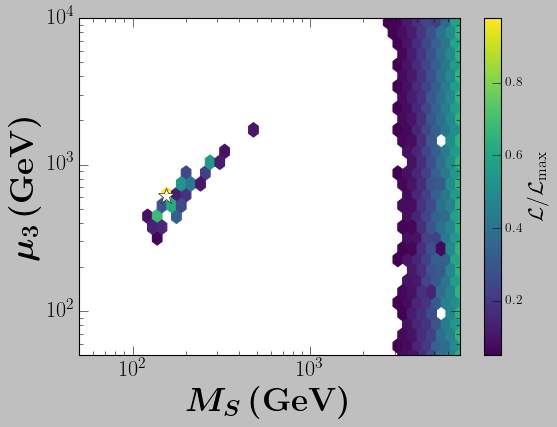

In [34]:
plt.figure(figsize=(7.2,5.5))
#plt.hexbin(arr_mS_mu3_2[:,0],arr_mS_mu3_2[:,1],-2*np.log(arr_mS_mu3_2[:,2]/Lmax2),gridsize=35,xscale='log',yscale='log',alpha=1, cmap = "viridis")
#c.set_label(r'$\Delta\chi^2$',size=20)
plt.hexbin(arr_mS_mu3_2[:,0],arr_mS_mu3_2[:,1], arr_mS_mu3_2[:,2]/Lmax2,gridsize=35,xscale='log',yscale='log',alpha=1, cmap = "viridis")
c=plt.colorbar()
c.set_label(r'$\mathcal{L}/\mathcal{L}_{\rm max}$',size=20)
plt.plot(bestfitydata2["mS"],bestfitydata2["mu3"],'w*', markersize=15)
plt.xlabel(r'$\boldsymbol{M_{S}\,(\rm{GeV})}$',size=30)
plt.ylabel(r'$\boldsymbol{\mu_3\,(\rm{GeV})}$',size=30)
plt.xlim(50,7000)
plt.ylim(50,10000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()